In [1]:
import gym
from collections import deque
import numpy as np
import time
import matplotlib.pyplot as plt

import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

torch.manual_seed(0) # set random seed
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### NO BASELINE

In [2]:

class Policy(nn.Module):
    def __init__(self, s_size=6, h_size=32, a_size=3):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item() - 1, m.log_prob(action)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:

env = gym.make('Acrobot-v1')
env.seed(0)
print('observation space:', env.observation_space)
print('action space:', env.action_space)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def reinforce(n_episodes=5000, max_t=1000, gamma=0.99, print_every=100):
    policy = Policy().to(device)
    optimizer = optim.Adam(policy.parameters(), lr=0.001)

    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])

        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        # if i_episode % print_every == 0:
        #     torch.save(policy.state_dict(), 'checkpoint.pth')
        #     print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
    return scores

# scores = reinforce()

observation space: Box([ -1.        -1.        -1.        -1.       -12.566371 -28.274334], [ 1.        1.        1.        1.       12.566371 28.274334], (6,), float32)
action space: Discrete(3)


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Completed run 1, 
Completed run 2, 
Completed run 3, 
Completed run 4, 
Completed run 5, 


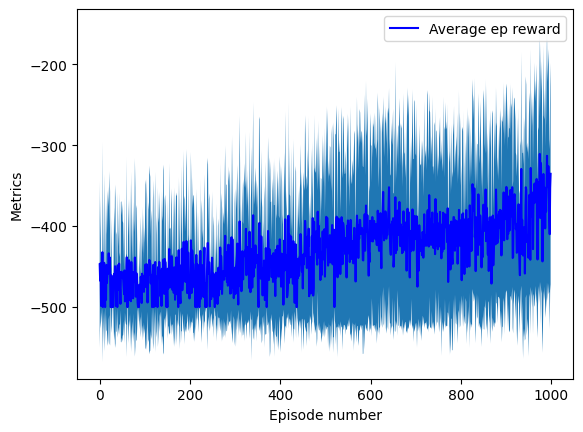

In [4]:
num_episodes = 1000
num_runs = 5

def runs():
    run_hist = np.zeros((num_runs, num_episodes))

    for i in range(num_runs):
      ep_hist = reinforce(n_episodes = 1000)
      print("Completed run {}, ".format(i+1))
      run_hist[i,:] = np.array(ep_hist).reshape((-1,))

    avg_run = np.mean(run_hist, axis=0)
    std_run = np.std(run_hist, axis=0)
    return avg_run, std_run

avg_run, std_run = runs()

plt.plot(avg_run, 'b-', label="Average ep reward")
plt.fill_between(list(range(num_episodes)), avg_run + std_run, avg_run - std_run)
plt.xlabel("Episode number")
plt.ylabel("Metrics")
plt.legend()
plt.show()

### BASELINE

In [5]:

class BaselinePolicy(nn.Module):
    def __init__(self, s_size=6, h_size=32, a_size=3, v_size=1):
        super(BaselinePolicy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)
        self.fc3 = nn.Linear(s_size, h_size)
        self.fc4 = nn.Linear(h_size, v_size)

    def forward(self, x):
        a_x = F.relu(self.fc1(x))
        a_x = self.fc2(a_x)
        v_x = F.relu(self.fc3(x))
        v_x = self.fc4(v_x)
        return F.softmax(a_x, dim=1), v_x

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs, state_value = self.forward(state)
        m = Categorical(probs)
        action = m.sample()
        return action.item() - 1, m.log_prob(action), state_value

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:


def reinforce_baseline(policy, optimizer, n_episodes=5000, max_t=1000, gamma=0.99, print_every=100):

    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        saved_log_probs, saved_state_values = [], []
        rewards = []
        state = env.reset()
        for t in range(max_t):
            action, log_prob, state_value = policy.act(state)
            saved_log_probs.append(log_prob)
            saved_state_values.append(state_value)
            state, reward, done, _= env.step(action)
            rewards.append(reward)
            if done:
                break
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])

        policy_loss = []
        for i,log_prob in enumerate(saved_log_probs):
            policy_loss.append(-log_prob * (R - saved_state_values[i]))
        policy_loss = torch.cat(policy_loss).sum()

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        # if i_episode % print_every == 0:
        #     torch.save(policy.state_dict(), 'checkpoint.pth')
        #     print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
    return scores

# scores = reinforce_baseline()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Completed run 1, 
Completed run 2, 
Completed run 3, 


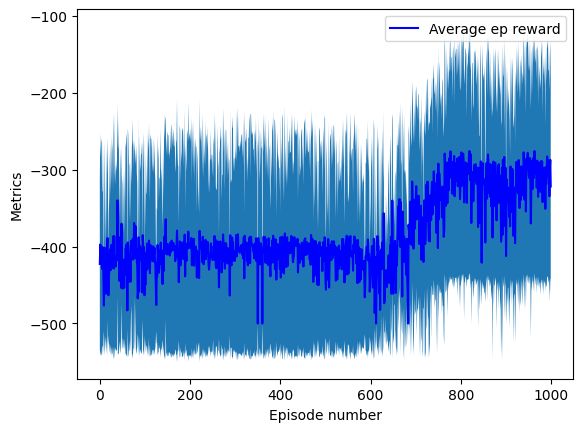

In [14]:
num_episodes = 1000
num_runs = 3

def runs_baseline():
    run_hist = np.zeros((num_runs, num_episodes))
    policy = BaselinePolicy().to(device)
    optimizer = optim.Adam(policy.parameters(), lr=0.001)

    for i in range(num_runs):
      ep_hist = reinforce_baseline(policy, optimizer, n_episodes = 1000)
      print("Completed run {}, ".format(i+1))
      run_hist[i,:] = np.array(ep_hist).reshape((-1,))

    avg_run = np.mean(run_hist, axis=0)
    std_run = np.std(run_hist, axis=0)
    return avg_run, std_run

avg_run_b, std_run_b = runs_baseline()

plt.plot(avg_run_b, 'b-', label="Average ep reward")
plt.fill_between(list(range(num_episodes)), avg_run_b + std_run_b, avg_run_b - std_run_b)
plt.xlabel("Episode number")
plt.ylabel("Metrics")
plt.legend()
plt.show()